<a href="https://colab.research.google.com/github/pNTubil/SVM-WATER/blob/main/SVMWATER.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Training set: 8920 samples
Validation set: 1115 samples
Test set: 1115 samples


<ipython-input-7-7371634b7d3d>:125: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Importance", y="Feature", data=feature_importance, palette="viridis")


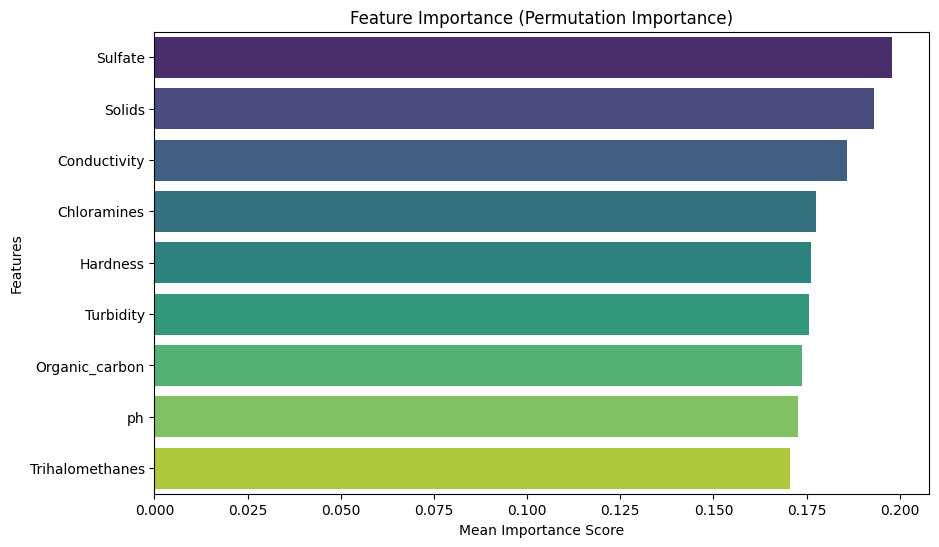

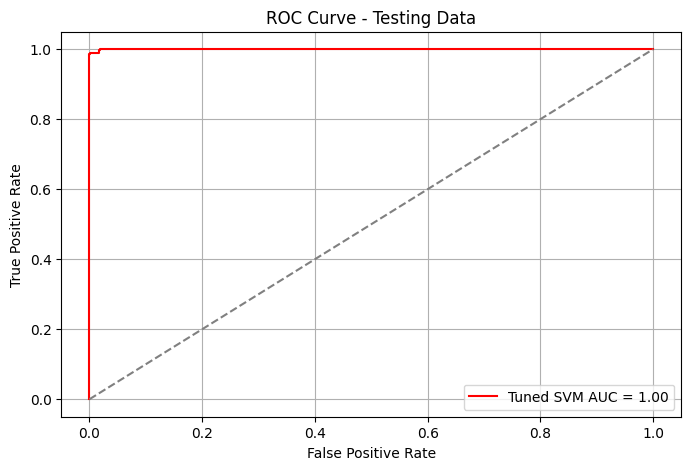

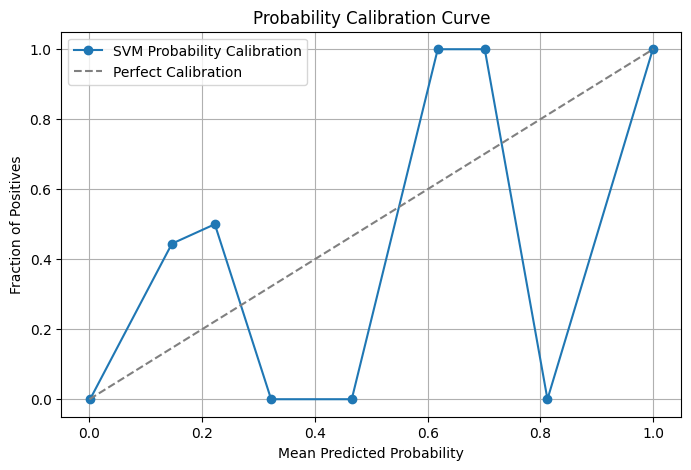

     Metric  Training  Validation   Testing
0  Accuracy       1.0    0.991031  0.993722
1  Log Loss       NaN         NaN  0.016391


In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             confusion_matrix, roc_curve, auc, log_loss)
from sklearn.calibration import calibration_curve
from sklearn.inspection import permutation_importance
from imblearn.over_sampling import SMOTE

# ----------------- Data Loading and Preprocessing -----------------
df = pd.read_csv("/content/water_potability-updated.csv")

# Handle missing values (fill with median)
df.fillna(df.median(), inplace=True)

# Features and target
X = df.drop("Potability", axis=1)
y = df["Potability"]

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply SMOTE before splitting to prevent data leakage
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_scaled, y)

# ----------------- 80-10-10 Splitting -----------------
# First split: 80% training, 20% temporary (validation + test)
X_train, X_temp, y_train, y_temp = train_test_split(
    X_resampled, y_resampled, test_size=0.20, stratify=y_resampled, random_state=42
)

# Second split: 10% validation, 10% test
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, stratify=y_temp, random_state=42
)

# Confirm sizes
print(f"Training set: {X_train.shape[0]} samples")
print(f"Validation set: {X_val.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

# ----------------- Refined Noise Injection -----------------
def augment_data_multi_noise(X, y, noise_std_list=None, copies_per_level=1, sample_fraction=0.4):
    """
    Generate augmented training data by selectively adding Gaussian noise.
    """
    if noise_std_list is None:
        noise_std_list = [0.005, 0.02]  # Default noise levels

    X = np.array(X)  # Convert to NumPy array to avoid KeyError
    y = np.array(y)  # Ensure labels are also NumPy arrays

    augmented_X = []
    augmented_y = []
    num_samples = int(sample_fraction * X.shape[0])

    # Generate random indices safely
    sampled_indices = np.random.choice(X.shape[0], num_samples, replace=False)

    for noise_std in noise_std_list:
        for _ in range(copies_per_level):
            noisy_copy = X[sampled_indices] + np.random.normal(loc=0, scale=noise_std, size=X[sampled_indices].shape)
            augmented_X.append(noisy_copy)
            augmented_y.append(y[sampled_indices])

    # Combine original data with noisy versions
    X_augmented = np.vstack([X] + augmented_X)
    y_augmented = np.concatenate([y] + augmented_y)

    return X_augmented, y_augmented

# ✅ Apply the fixed function (only augment training data)
X_train_aug, y_train_aug = augment_data_multi_noise(X_train, y_train)

# ----------------- Weighted SVM Training -----------------
class_weights = {0: 1, 1: len(y_train_aug) / sum(y_train_aug)}
svm_base = SVC(kernel="rbf", class_weight=class_weights, random_state=42, probability=True)
svm_base.fit(X_train_aug, y_train_aug)

# ----------------- Hyperparameter Tuning -----------------
param_grid = {
    'C': np.logspace(-3, 2, 5),
    'gamma': np.logspace(-3, 0, 4)
}

svm_tuned = RandomizedSearchCV(
    SVC(kernel="rbf", class_weight=class_weights, random_state=42, probability=True),
    param_distributions=param_grid,
    n_iter=10,
    cv=StratifiedKFold(n_splits=5),
    random_state=42,
    n_jobs=-1
)
svm_tuned.fit(X_train_aug, y_train_aug)

# ----------------- Evaluation -----------------
train_accuracy_tuned = accuracy_score(y_train, svm_tuned.predict(X_train))
val_accuracy_tuned = accuracy_score(y_val, svm_tuned.predict(X_val))
test_accuracy_tuned = accuracy_score(y_test, svm_tuned.predict(X_test))

y_test_prob_tuned = svm_tuned.predict_proba(X_test)[:, 1]

# Log Loss Metric (Measures Probability Calibration)
log_loss_score = log_loss(y_test, y_test_prob_tuned)

# ----------------- Feature Importance (Permutation Importance) -----------------
perm_importance = permutation_importance(svm_tuned, X_test, y_test, scoring="accuracy", n_repeats=5, random_state=42)
feature_importance = pd.DataFrame({
    "Feature": df.drop("Potability", axis=1).columns,
    "Importance": perm_importance.importances_mean
}).sort_values(by="Importance", ascending=False)

# ----------------- Probability Calibration Curve -----------------
prob_true, prob_pred = calibration_curve(y_test, y_test_prob_tuned, n_bins=10)

# ----------------- Plot Results -----------------
# Feature Importance
plt.figure(figsize=(10, 6))
sns.barplot(x="Importance", y="Feature", data=feature_importance, palette="viridis")
plt.xlabel("Mean Importance Score")
plt.ylabel("Features")
plt.title("Feature Importance (Permutation Importance)")
plt.show()

# ROC Curve
fpr_tuned, tpr_tuned, _ = roc_curve(y_test, y_test_prob_tuned)
plt.figure(figsize=(8, 5))
plt.plot(fpr_tuned, tpr_tuned, label=f"Tuned SVM AUC = {auc(fpr_tuned, tpr_tuned):.2f}", color="red")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Testing Data")
plt.legend()
plt.grid(True)
plt.show()

# Calibration Curve
plt.figure(figsize=(8, 5))
plt.plot(prob_pred, prob_true, marker="o", label="SVM Probability Calibration")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Perfect Calibration")
plt.xlabel("Mean Predicted Probability")
plt.ylabel("Fraction of Positives")
plt.title("Probability Calibration Curve")
plt.legend()
plt.grid(True)
plt.show()

# ----------------- Display Metrics -----------------
metrics_df = pd.DataFrame({
    "Metric": ["Accuracy", "Log Loss"],
    "Training": [train_accuracy_tuned, None],
    "Validation": [val_accuracy_tuned, None],
    "Testing": [test_accuracy_tuned, log_loss_score]
})
print(metrics_df)